In [1]:
from drn_interactions.transforms.spikes import SpikesHandlerMulti
from drn_interactions.config import Config, ExperimentInfo
from drn_interactions.io import load_events, load_derived_generic
from drn_interactions.responders.foot_shock import SpikeRateResponders
import pandas as pd
import numpy as np
from IPython.display import display
from scipy.stats import zscore

%load_ext autoreload
%autoreload 2

# Slow Timescale Effects

In [2]:

sessions = list(ExperimentInfo.foot_shock_sessions_10min)
neuron_types = (
    load_derived_generic("neuron_types.csv")
    .assign(neuron_type=lambda x: pd.Categorical(x.neuron_type, categories=["SR", "SIR", "FF"], ordered=True))
)
spikes_handler = SpikesHandlerMulti(
    block=["base_shock", "post_base_shock"], 
    bin_width=1, 
    session_names=sessions,
    t_start=-600, 
    t_stop=1200,
)
df = (
    spikes_handler.binned
    .merge(neuron_types)
    .assign(
        block=lambda x: np.select(
            [x["bin"] < 0, x["bin"] < 600, x["bin"] < 1200],
            ["1Pre", "2Shock", "3Post"],
            )
        )
    .assign(zcounts=lambda x: x.groupby("neuron_id")["counts"].transform(zscore))
)

In [3]:
mod = SpikeRateResponders(
    df_value_col="zcounts", 
    round_output=2, 
    within_first=True,
    anova_contrast_interaction=True,
    )
anova, contrasts = mod.get_anova(df, fit_neuron_types=True, )

contrasts=(
    contrasts
    .query("A in ('1Pre', '2Shock', '3Post') or block in ('2Shock', '3Post') ")
    .loc[:, ["block", "A", "B", "mean(A)", "mean(B)", "T", "dof", "p-corr", "Sig"]]
)
anova = (
    anova
    .loc[:, ["Source",  "F",  "DF1", "p-unc"]]
)
display(anova)
display(contrasts)

/opt/miniconda3/envs/drn/lib/python3.8/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Source,F,DF1,p-unc
0,neuron_type,2.07,2,0.13
1,block,83.60,2,0.00
2,Interaction,1.61,4,0.17


,block,A,B,mean(A),mean(B),T,dof,p-corr,Sig
0,-,1Pre,2Shock,0.07,0.27,-3.50,258.00,0.00,*
1,-,1Pre,3Post,0.07,-0.34,10.47,258.00,0.00,*
2,-,2Shock,3Post,0.27,-0.34,12.54,258.00,0.00,*
9,2Shock,SR,SIR,0.29,0.29,-0.02,223.71,0.99,
10,2Shock,SR,FF,0.29,0.12,1.45,41.98,0.32,
11,2Shock,SIR,FF,0.29,0.12,1.48,39.76,0.32,
12,3Post,SR,SIR,-0.40,-0.31,-1.70,212.08,0.32,
13,3Post,SR,FF,-0.40,-0.27,-1.37,40.56,0.32,
14,3Post,SIR,FF,-0.31,-0.27,-0.53,36.04,0.75,


In [4]:
mod_counts = SpikeRateResponders(
    df_value_col="counts", 
    round_output=2, 
    within_first=False,
    anova_contrast_interaction=True,
    )
anova, contrasts = mod_counts.get_anova(df, fit_neuron_types=True, )

contrasts=(
    contrasts
    # .query("A in ('1Pre', '2Shock', '3Post') or block in (, 2Shock', '3Post') ")
    # .loc[:, ["block", "A", "B", "mean(A)", "mean(B)", "T", "dof", "p-corr", "Sig"]]
)

anova = (
    anova
    .loc[:, ["Source",  "F",  "DF1", "p-unc"]]
)
display(anova)
display(contrasts)

/opt/miniconda3/envs/drn/lib/python3.8/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Source,F,DF1,p-unc
0,neuron_type,73.15,2,0.00
1,block,29.95,2,0.00
2,Interaction,1.45,4,0.22


,Contrast,neuron_type,A,B,mean(A),std(A),mean(B),std(B),T,dof,p-corr,p-adjust,p,Sig
0,neuron_type,-,SR,SIR,3.46,2.72,2.13,2.30,3.98,215.74,0.00,fdr_bh,0.00,*
1,neuron_type,-,SR,FF,3.46,2.72,10.27,6.82,-5.35,31.53,0.00,fdr_bh,0.00,*
2,neuron_type,-,SIR,FF,2.13,2.30,10.27,6.82,-6.44,30.69,0.00,fdr_bh,0.00,*
3,block,-,1Pre,2Shock,3.65,4.07,4.63,6.04,-3.24,258.00,0.00,fdr_bh,0.00,*
4,block,-,1Pre,3Post,3.65,4.07,2.66,3.81,6.86,258.00,0.00,fdr_bh,0.00,*
5,block,-,2Shock,3Post,4.63,6.04,2.66,3.81,6.86,258.00,0.00,fdr_bh,0.00,*
6,neuron_type * block,SR,1Pre,2Shock,3.65,3.01,4.09,3.72,-1.70,110.00,0.10,fdr_bh,0.10,
7,neuron_type * block,SR,1Pre,3Post,3.65,3.01,2.64,2.40,5.41,110.00,0.00,fdr_bh,0.00,*
8,neuron_type * block,SR,2Shock,3Post,4.09,3.72,2.64,2.40,5.39,110.00,0.00,fdr_bh,0.00,*
9,neuron_type * block,SIR,1Pre,2Shock,1.88,1.84,3.40,5.74,-2.94,117.00,0.01,fdr_bh,0.01,*


In [25]:
anovas, contrast_dict = mod.get_responders(df)
(
    anovas
    .merge(neuron_types[["session_name", "neuron_id", "neuron_type"]])
    .to_csv(Config.derived_data_dir / "slow_ts_foot_shock_unit_anovas.csv", index=False)
)

for constrast_name, contrast_df in contrast_dict.items():
    (
        contrast_df
        .merge(neuron_types[["session_name", "neuron_id", "neuron_type"]])
        .to_csv(Config.derived_data_dir / f"slow_ts_foot_shock_unit_responders_{constrast_name}.csv", index=False)
    )

## Time-Locked Effects

In [26]:
from drn_interactions.transforms.shock_transforms import ShockUtils
from drn_interactions.transforms.spikes import SpikesHandler
from drn_interactions.responders.foot_shock import AlignedResponders

sessions = ExperimentInfo.foot_shock_sessions_all
spikes = SpikesHandler(
    block="base_shock",
    bin_width=1,
    session_names=sessions,
    t_start=0,
    t_stop=600,
).spikes.merge(neuron_types)
events = (
    load_events(block_name="base_shock")
    .query("event_s >= 0 and event_s <= 600")
)

transformer = ShockUtils()

df_binned = transformer.aligned_binned_from_spikes(
    spikes, 
    events, 
    sessions=None,
    bin_width=0.01,
    )

window = (0.05, 0.2)
df_psth = (
    transformer.average_trace_from_aligned_binned(
            df_binned
        )
        .reset_index()
        .melt(id_vars="bin", var_name="neuron_id", value_name="counts")
        .assign(zcounts=lambda x: x.groupby("neuron_id")["counts"].transform(zscore))
        .merge(neuron_types)
        .assign(window=lambda x: np.where(
            (x["bin"] < window[0]) | (x["bin"] > window[1]), "pre", "post"
        ))
)


In [29]:
mod = AlignedResponders(value_col="zcounts", round_output=2, within_first=True)
anova, contrasts = mod.get_anova(df_psth, fit_neuron_types=True)
responders = mod.get_responders(df_psth, abs_diff_thresh=0.2)
(
    responders
    .merge(neuron_types)
    .to_csv(Config.derived_data_dir / "fast_fs_foot_shock_unit_responders.csv", index=False)
)

contrasts=(
    contrasts
    .query("window != 'pre'")
)

anova = (
    anova
    .loc[:, ["Source",  "F",  "DF1", "p-unc"]]
)
display(anova)
display(contrasts)
display(responders.sample(3))


,Source,F,DF1,p-unc
0,neuron_type,8.59,2,0.0
1,window,13.99,1,0.0
2,Interaction,8.59,2,0.0


,Contrast,window,A,B,mean(A),std(A),mean(B),std(B),T,dof,p-corr,p-adjust,p,Sig
0,window,-,post,pre,0.25,1.11,-0.02,0.10,3.64,258.00,NaN,NaN,0.00,*
1,neuron_type,-,SR,SIR,-0.02,0.52,0.25,0.43,-4.21,213.90,0.00,fdr_bh,0.00,*
2,neuron_type,-,SR,FF,-0.02,0.52,0.09,0.57,-1.00,42.95,0.32,fdr_bh,0.32,
3,neuron_type,-,SIR,FF,0.25,0.43,0.09,0.57,1.36,37.82,0.27,fdr_bh,0.26,
4,window * neuron_type,post,SR,SIR,-0.05,1.15,0.54,0.95,-4.21,213.90,0.00,fdr_bh,0.00,*
5,window * neuron_type,post,SR,FF,-0.05,1.15,0.21,1.26,-1.00,42.95,0.32,fdr_bh,0.32,
6,window * neuron_type,post,SIR,FF,0.54,0.95,0.21,1.26,1.36,37.82,0.27,fdr_bh,0.26,


,neuron_id,n_pre,n_post,Mean_pre,Mean_post,Diff,U,p,sig
103,1733,184.0,16.0,0.00,-0.05,-0.05,1472.0,1.0,False
105,1736,184.0,16.0,-0.18,2.01,2.19,142.0,0.0,True
195,1899,184.0,16.0,0.10,-1.10,-1.19,2234.5,0.0,True


In [39]:
# counts 
mod = AlignedResponders(value_col="counts", within_first=False)
anova, contrasts = mod.get_anova(df_psth, fit_neuron_types=True)
contrasts["mean(A)"] = contrasts["mean(A)"] / 0.01
contrasts["std(A)"] = contrasts["std(A)"] / 0.01
contrasts["mean(B)"] = contrasts["mean(B)"] / 0.01
contrasts["std(B)"] = contrasts["std(B)"] / 0.01
display(contrasts.round(2))


,Contrast,neuron_type,A,B,mean(A),std(A),mean(B),std(B),T,dof,p-corr,p-adjust,p,Sig
0,neuron_type,-,SR,SIR,3.52,3.14,3.18,4.37,0.69,212.68,0.49,fdr_bh,0.57,
1,neuron_type,-,SR,FF,3.52,3.14,9.54,9.08,-3.57,30.90,0.00,fdr_bh,0.00,*
2,neuron_type,-,SIR,FF,3.18,4.37,9.54,9.08,-3.73,32.48,0.00,fdr_bh,0.00,*
3,window,-,post,pre,4.41,6.30,3.71,4.37,3.12,258.00,NaN,NaN,0.00,*
4,neuron_type * window,SR,post,pre,3.57,4.11,3.47,2.60,0.38,110.00,0.71,fdr_bh,0.71,
5,neuron_type * window,SIR,post,pre,3.76,5.78,2.60,3.30,3.60,117.00,0.00,fdr_bh,0.00,*
6,neuron_type * window,FF,post,pre,10.10,10.77,8.98,8.15,1.05,29.00,0.46,fdr_bh,0.43,


In [19]:
def get_psth_subset(
    t_start, 
    t_stop, 
    block="base_shock", 
    sessions=None, 
    window=(0.05, 0.2)
    ):
    sessions = sessions or ExperimentInfo.foot_shock_sessions_all
    spikes = SpikesHandler(
        block=block,
        bin_width=1,
        session_names=sessions,
        t_start=t_start,
        t_stop=t_stop,
    ).spikes.merge(neuron_types)
    events = (
        load_events(block_name=block)
        .query("event_s >=  @t_start and event_s <= @t_stop")
    )
    transformer = ShockUtils()
    df_binned = transformer.aligned_binned_from_spikes(
        spikes, 
        events, 
        sessions=None,
        bin_width=0.01,
        )
    df_psth = (
        transformer.average_trace_from_aligned_binned(
                df_binned
            )
            .reset_index()
            .melt(id_vars="bin", var_name="neuron_id", value_name="counts")
            .assign(zcounts=lambda x: x.groupby("neuron_id")["counts"].transform(zscore))
            .merge(neuron_types[["neuron_id", "neuron_type", "session_name"]].drop_duplicates())
            .assign(window=lambda x: np.where(
                (x["bin"] < window[0]) | (x["bin"] > window[1]), "pre", "post"
            ))
    )
    return df_psth

def get_response(df, sig_col="sig", diff_col="Diff"):
    return np.where(
        df[sig_col] == True, 
        np.where(df[diff_col] > 0, "activated", "inhibited"), 
        "non responder")


df_psth_first_half = get_psth_subset(t_start=0, t_stop=300, sessions=sessions)
df_psth_second_half = get_psth_subset(t_start=300, t_stop=600, sessions=sessions)

responders_first_half = mod.get_responders(df_psth_first_half, abs_diff_thresh=0.2)
responders_second_half = mod.get_responders(df_psth_second_half, abs_diff_thresh=0.2)

responders_first_half["response_first_half"] = get_response(responders_first_half)
responders_second_half["response_second_half"] = get_response(responders_second_half)

df_responders = (
    responders_first_half[["neuron_id", "response_first_half"]]
    .merge(
        responders_second_half[["neuron_id", "response_second_half"]],
    )
)



In [31]:
idx = responders_first_half.sort_values("Diff").neuron_id.values

In [34]:
# sort both by diff
(
    df_psth_first_half
    .pivot(
        index="neuron_id", 
        columns="bin",
        values="counts",
    )
    .reindex(idx)
    .dropna()
    .to_csv(Config.derived_data_dir / "psth_first_half.csv", index=True)
)
(
    df_psth_second_half
    .pivot(
        index="neuron_id", 
        columns="bin",
        values="counts",
    )
    .reindex(idx)
    .dropna()
    .to_csv(Config.derived_data_dir / "psth_second_half.csv", index=True)
)

c:\Users\roryl\.conda\envs\drn38\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
c:\Users\roryl\.conda\envs\drn38\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [8]:
from sklearn.metrics import mutual_info_score
import ezbootstrap as ez
from sklearn.preprocessing import LabelEncoder
from drn_interactions.stats import se_mean

le = LabelEncoder()

x = le.fit_transform(df_responders["response_first_half"])
y = le.transform(df_responders["response_second_half"])


obs = mutual_info_score(x, y)
obs_reps = ez.bs_pairs(x, y, func=lambda x, y : mutual_info_score(x, y), size=1000)

shuffle_reps = ez.permutation_2sample_independent(
    x, y, func=lambda x, y : mutual_info_score(x, y), size=1000
)

c:\Users\roryl\.conda\envs\drn38\lib\site-packages\ezbootstrap\core.py:157: UserWarning: Numba compilation failed. Reverting to pure python
  warnings.warn("Numba compilation failed. Reverting to pure python")
c:\Users\roryl\.conda\envs\drn38\lib\site-packages\ezbootstrap\core.py:209: UserWarning: Numba compilation failed. Reverting to pure python
  warnings.warn("Numba compilation failed. Reverting to pure python")


In [10]:
print(obs_reps.mean(), se_mean(obs_reps))

print(shuffle_reps.mean(), se_mean(shuffle_reps))

0.4075361959297718 0.0013119804156932794
0.008111919047763065 0.00018172426606141834


In [35]:
from drn_interactions.plots import PAL_GREY_BLACK
import seaborn as sns

dfp = pd.DataFrame(
    {"Observed": obs_reps, "Shuffled": shuffle_reps},
).melt(id_vars=None, var_name="Method", value_name="MI")

dfp.to_csv(Config.derived_data_dir / "mi_psth_halfs.csv", index=False)
# sns.barplot(data=dfp, x="Method", y="MI", palette=PAL_GREY_BLACK)

c:\Users\roryl\.conda\envs\drn38\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\roryl\.conda\envs\drn38\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


Text(13.699999999999996, 0.5, 'Neuron Count')

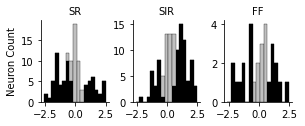

In [9]:
from drn_interactions.plots import PAL_GREY_BLACK
import seaborn as sns
g = (
    responders
    .merge(neuron_types)
    .pipe(sns.FacetGrid, col="neuron_type", sharey=False, height=1.5, aspect=0.9, gridspec_kws=dict(wspace=0.35))
    .map_dataframe(
        sns.histplot, 
        x="Diff", 
        hue="sig", 
        palette=PAL_GREY_BLACK[::-1],
        multiple="stack",
        bins=np.arange(-2.6, 2.6, 0.3),
        alpha=1)
    .add_legend()
    .set_titles("{col_name}")
    .set_xlabels("")
    .set_ylabels("Counts")
)
g.axes[0, 0].set_ylabel("Neuron Count")